Code for dataloader

In [8]:
import os
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class LOLPairedDataset(Dataset):
    def __init__(self, low_dir, bright_dir, transform=None):
        self.low_paths = sorted(list(Path(low_dir).glob("*.png")))
        self.bright_paths = sorted(list(Path(bright_dir).glob("*.png")))
        assert len(self.low_paths) == len(self.bright_paths), "Mismatch in image pairs"
        self.transform = transform

    def __getitem__(self, idx):
        low = Image.open(self.low_paths[idx]).convert("RGB")
        bright = Image.open(self.bright_paths[idx]).convert("RGB")

        if self.transform:
            low, bright = self.transform(low, bright)
        return {"low": low, "bright": bright}

    def __len__(self):
        return len(self.low_paths)


Transform pipeline for data augmentation

In [7]:
from torchvision import transforms
import random
from PIL import Image

class PairedTransforms:
    def __init__(self, image_size=(400, 600)):
        self.image_size = image_size

        # Define shared random transforms
        self.augment = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(self.image_size),
        ])

        # Define tensor conversion and normalization
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),  # [0,255] → [0,1]
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # [0,1] → [-1,1]
        ])

    def __call__(self, low_img, bright_img):
        # Apply same random seed for paired transform
        seed = random.randint(0, 2**32)
        random.seed(seed)
        low_img = self.augment(low_img)
        random.seed(seed)
        bright_img = self.augment(bright_img)

        # To tensor + normalize
        low_img = self.to_tensor(low_img)
        bright_img = self.to_tensor(bright_img)

        return low_img, bright_img


Sample code to load the data

In [14]:
train_transform = PairedTransforms(image_size=(400, 600))
train_dataset = LOLPairedDataset(train_low, train_bright, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

sample code to show the pairs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


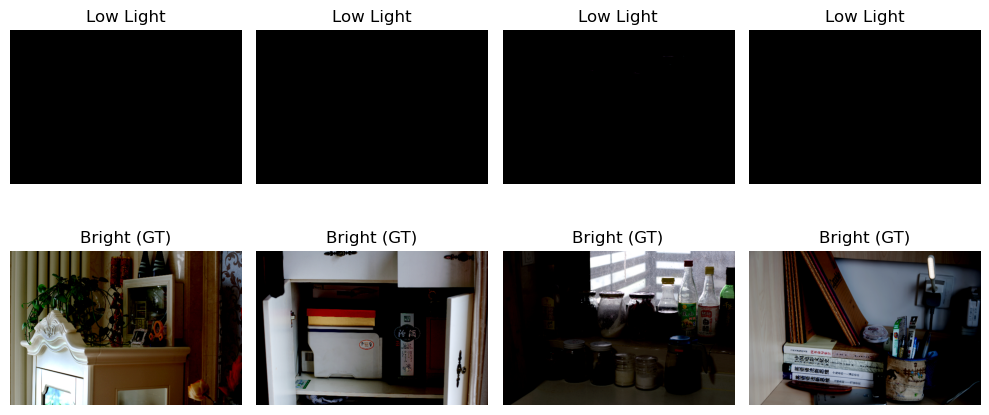

In [15]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Get a batch of data
batch = next(iter(train_loader))
low_imgs = batch["low"]     # shape: [B, 3, H, W]
bright_imgs = batch["bright"]

# Convert from tensor [C,H,W] to numpy [H,W,C] for display
def show_tensor_image(tensor_img, title="Image"):
    img = tensor_img.permute(1, 2, 0).cpu().numpy()  # [C,H,W] → [H,W,C]
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)

# Plot the first 4 low/bright pairs
num_to_show = 4
plt.figure(figsize=(10, 5))
for i in range(num_to_show):
    plt.subplot(2, num_to_show, i + 1)
    show_tensor_image(low_imgs[i], title="Low Light")
    
    plt.subplot(2, num_to_show, i + 1 + num_to_show)
    show_tensor_image(bright_imgs[i], title="Bright (GT)")

plt.tight_layout()
plt.show()
